In [1]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import spacy
spc_nlp = spacy.load('en')

In [3]:
root = 'data/ICNALE/Unmerged_classified'
#root = 'data/pilot3'

In [4]:
df_orig = pwk.load_data_multi(root)
df_orig.head(1)

5600


,doc_id,path,author_code,essay_content,label
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN


In [5]:
df_orig['topic'] = df_orig['author_code'].apply(lambda x: x[6:9])

In [6]:
cond = (df_orig['label']=='HKG')|(df_orig['label']=='TWN')
df_0 = df_orig.drop(df_orig[cond].index, axis=0)

In [7]:
countries = list(df_0.groupby('label').size().index)
sample_count = df_0.groupby('label').size().values

In [8]:
countries

['CHN', 'ENS', 'IDN', 'JPN', 'KOR', 'PAK', 'PHL', 'SIN', 'THA']

/Users/ziru/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


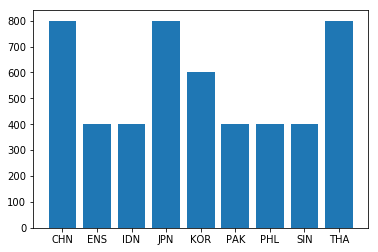

In [9]:
fig, ax = plt.subplots()
ax.bar(range(len(countries)), sample_count)
#ax.xticks = countries
plt.xticks(range(len(countries)), countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

**-**

In [10]:
df_0 = pd.read_pickle('df_syntactic_20180109.pkl')

In [11]:
df_0.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join'],
      dtype='object')

In [12]:
lmtzr = WordNetLemmatizer()
df_0['doc2vec_lm_token'] = df_0['essay_content'].apply(lambda x: [token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])

In [13]:
df_0.to_pickle('df_doc2vec_20180110.pkl')

### Generate dep/pos ngrams

In [107]:
df_0.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join', u'doc2vec_lm_token', u'DT_insent_arch_ngram',
       u'DT_insent_pos_ngram'],
      dtype='object')

In [118]:
n = 3
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [15]:
n = 3
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

### Training Doc2Vec model using text body of different natures (actual terms, pos, dep)

**I thought about train a model for each language class, but it turns out that it is not the right way to train doc2vec models. doc2vec model should train all documents once, and the idea is the catch document characteristics in the process when all documents are in the picture**

In [124]:
cond = (df_0['label']=='ENS')|(df_0['label']=='CHN')#|(df_0['label']=='JPN')|(df_0['label']=='THA')

# df_d2vs = pd.DataFrame()
# for c in countries:
#     cond = (df_0['label']==c)
#     df_input = df_0[cond]
#     sen = pwk.label_sentences(df_input, 'doc2vec_lm_token')
#     model = pwk.train_doc2vec_model(sen, 1, 50)
#     df_d2v = pwk.vectorize_comments(df_input, model, 'vectorized_essay')
#     df_d2vs = df_d2vs.append(df_d2v)

df_input = df_0[cond]
sen = pwk.label_sentences(df_input, 'DT_insent_arch_ngram')
#model = pwk.train_doc2vec_model(sen)
model = pwk.train_doc2vec_model(sen, 5, 100)
df_d2v = pwk.vectorize_comments(df_input, model, 'vectorized_essay')

In [125]:
#X = df_d2vs['vectorized_essay'].tolist()
#y = df_d2vs['label']
X = df_d2v['vectorized_essay'].tolist()
y = df_d2v['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [126]:
accuracy_score(y_test, y_pred)

0.83333333333333337